# BERT Text Classification - Binary dataset

This experiment aims to use BERT for text classification on the Review Polarity dataset, available at The data used here is available in the [Text Collections](https://github.com/ragero/text-collections/tree/master/complete_texts_csvs) Github repo.

The code in this notebook was heavily inspired by the Chapter 2 of the book [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/).

## Dependencies installation

In [ ]:
!pip install datasets evaluate accelerate
!pip install "numpy<2.0"

## Data

In [ ]:
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("csv", data_files="/content/review_polarity.csv")
dataset = dataset.rename_column("class", "label")

# We want to stratify the split based on labels occurrence
df = dataset["train"].to_pandas()

# Whole dataset into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)

# Temp into validation (10%) and test (20%) with stratification
valid_df, test_df = train_test_split(temp_df, test_size=2/3, stratify=temp_df["label"], random_state=42)

# Back to HuggingFace interface
dataset = DatasetDict({
    'train': dataset["train"].from_pandas(train_df),
    'validation': dataset["train"].from_pandas(valid_df),
    'test': dataset["train"].from_pandas(test_df)
})

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 200
    })
    test: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 400
    })
})

## Mapping labels to integer

The classification model asks for a number label instead of a string label.

In [4]:
label_names = [
    'neg',
    'pos'
]

label_mapping = {label: idx for idx, label in enumerate(label_names)}

In [5]:
def map_to_int(example, label_mapping: dict):
  int_label = label_mapping.get(example["label"])
  example["label"] = int_label
  return example

In [6]:
# sanity check for the mapping function
labels = set()
for elem in dataset["train"]:
  labels.add(elem["label"])

print(labels)

{'neg', 'pos'}


In [ ]:
dataset = dataset.map(lambda x: map_to_int(x, label_mapping))

## Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [9]:
# tokenizer example
s = "Today is a beautiful day!"
encoded_text = tokenizer(s)
print(encoded_text)

{'input_ids': [101, 2651, 2003, 1037, 3376, 2154, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [10]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'today', 'is', 'a', 'beautiful', 'day', '!', '[SEP]']


In [11]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] today is a beautiful day! [SEP]


Helper function to apply later.

In [12]:
def tokenize(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [13]:
print(tokenize(dataset["train"][0]))

{'input_ids': [101, 2160, 2006, 11171, 2940, 1006, 2639, 1007, 4626, 28117, 2063, 10667, 5620, 1010, 11023, 5481, 1010, 4862, 2474, 19418, 1010, 6904, 2213, 3489, 5553, 14416, 1010, 2848, 17297, 1010, 19218, 2618, 4267, 1010, 4098, 2566, 18337, 1010, 7059, 8840, 15878, 1010, 2508, 7733, 7747, 1010, 1998, 3782, 10645, 5794, 1012, 2856, 2011, 2520, 16321, 1010, 2517, 2011, 5980, 10506, 4783, 1010, 1000, 2160, 2006, 11171, 2940, 1000, 3988, 10057, 2993, 2000, 1996, 4378, 2007, 1037, 3496, 5994, 11798, 1011, 2066, 5177, 5022, 7866, 1998, 21054, 7435, 1999, 1996, 2175, 5134, 2102, 3971, 2825, 1012, 2028, 3460, 2003, 2730, 6880, 2044, 2383, 1037, 14745, 27653, 3294, 2083, 2010, 3300, 1012, 1037, 6821, 2038, 2014, 2132, 3140, 2046, 1037, 8460, 1997, 2300, 1012, 2122, 11240, 2015, 1997, 14106, 3591, 2024, 2066, 2216, 1999, 3025, 1038, 1011, 5469, 17312, 2015, 1010, 2007, 20696, 2075, 14950, 1998, 28353, 22208, 3560, 5750, 1012, 3272, 2023, 2051, 1010, 2012, 1996, 2203, 1997, 1996, 4971, 18595,

In [14]:
print(dataset["train"][0]["label"])

0


For the whole data now!

In [ ]:
encoded_data = dataset.map(tokenize, batched=True)

In [16]:
print(encoded_data["train"].column_names)

['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']


In [17]:
encoded_data

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

## Training

In [ ]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [19]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [20]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [21]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [22]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [23]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [24]:
encoded_data["train"].column_names

['file_name',
 'text',
 'label',
 '__index_level_0__',
 'input_ids',
 'attention_mask']

In [25]:
encoded_data.set_format("torch", columns=['file_name', 'text', 'label', 'input_ids', 'attention_mask'])

In [ ]:
data_hidden = encoded_data.map(extract_hidden_states, batched=True, batch_size=100)

In [27]:
data_hidden["train"].column_names

['file_name',
 'text',
 'label',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [28]:
data_hidden["train"]["hidden_state"][0]

tensor([ 2.1046e-02, -2.2995e-01,  4.8103e-02, -8.1167e-02, -5.9964e-02,
        -8.3196e-02,  3.3762e-01, -8.5760e-02,  2.5040e-03,  1.8974e-03,
        -1.0378e-02, -1.4504e-01, -1.2628e-01,  4.6319e-01, -3.7452e-02,
         2.7707e-01,  8.9177e-02,  2.4613e-01,  6.6197e-02, -1.5857e-01,
        -7.4846e-03, -3.2314e-01,  3.4620e-01,  3.6076e-01, -3.7959e-01,
         3.4171e-02,  3.7418e-02, -2.3746e-02,  5.0614e-02,  7.5202e-02,
         2.3202e-01, -6.1219e-02, -2.5068e-01, -4.5994e-01,  1.6415e-01,
        -3.3903e-01, -1.0373e-01, -5.3935e-02,  4.6981e-02,  2.3073e-02,
         3.6309e-02,  1.7253e-01,  2.6399e-02, -3.9262e-01, -9.5592e-02,
        -3.7309e-01, -3.1044e+00,  3.6653e-02, -4.0894e-01, -1.9397e-02,
         3.0404e-01,  1.6312e-01,  9.2964e-02,  1.7615e-01,  3.6439e-01,
         2.6084e-01, -4.1530e-01,  3.0622e-01,  3.0697e-03,  2.0341e-01,
         2.5906e-01,  1.3314e-01, -1.1581e-01, -1.3612e-01, -1.0306e-01,
         1.5431e-02, -3.2213e-01,  3.0001e-01, -1.8

Here we select the type of fine-tuning that we want to apply. For a text classification task, we can go with a Sequence Classification flavor in the HuggingFace framework.

In [29]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(encoded_data["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-polarity"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["validation"],
    tokenizer=tokenizer
)

trainer.train();

<ipython-input-33-0e1cdc339e6e>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.615700,0.407268,0.840000,0.839212
2,0.357800,0.348729,0.855000,0.853945
3,0.222400,0.357987,0.855000,0.853384
4,0.132200,0.329244,0.880000,0.879988
5,0.075100,0.404694,0.870000,0.869883
6,0.052300,0.452403,0.875000,0.874847
7,0.021500,0.505548,0.875000,0.874922
8,0.014100,0.534129,0.875000,0.874997
9,0.019600,0.550781,0.875000,0.874997
10,0.008000,0.569435,0.875000,0.874997


In [ ]:
trainer.push_to_hub()

## Evaluation

In [35]:
trainer.evaluate(encoded_data["test"])

{'eval_loss': 0.43156173825263977,
 'eval_accuracy': 0.8975,
 'eval_f1': 0.8974480830920654,
 'eval_runtime': 5.9328,
 'eval_samples_per_second': 67.422,
 'eval_steps_per_second': 2.191,
 'epoch': 10.0}

In [36]:
test_preds = trainer.predict(encoded_data['test'])

              precision    recall  f1-score   support

         neg       0.92      0.88      0.90       200
         pos       0.88      0.92      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



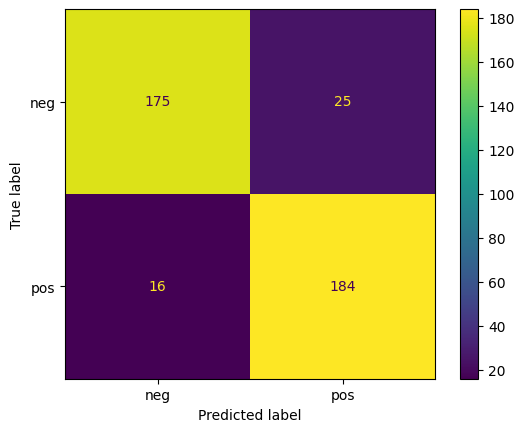

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np


print(classification_report(
    y_true=test_preds.label_ids,
    y_pred=np.argmax(test_preds.predictions, axis=1),
    target_names=["neg", "pos"]
))

ConfusionMatrixDisplay.from_predictions(y_true=test_preds.label_ids,
                                        y_pred=np.argmax(test_preds.predictions, axis=1),
                                        display_labels=["neg", "pos"])

plt.show()

## Comparision with a baseline model

Numbers of a standard SVM + TF-IDF model on the same split.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

tfidf = TfidfVectorizer()

X_train_csr = tfidf.fit_transform(train_df["text"])
X_test_csr = tfidf.transform(test_df["text"])

svm = SVC()

svm.fit(X_train_csr, [0 if elem == "neg" else 1 for elem in train_df["label"]])

preds_svm = svm.predict(X_test_csr)

              precision    recall  f1-score   support

         neg       0.82      0.77      0.80       200
         pos       0.78      0.83      0.81       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



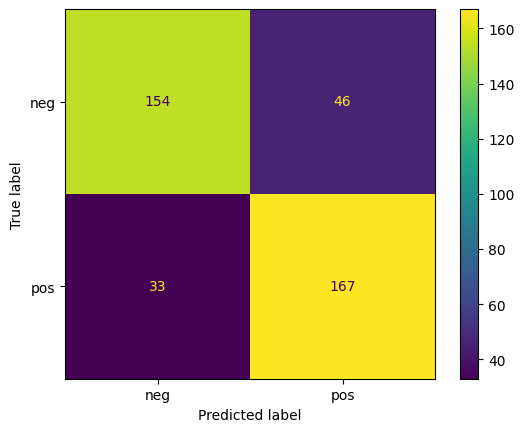

In [49]:
print(classification_report(
    y_true=test_preds.label_ids,
    y_pred=preds_svm,
    target_names=["neg", "pos"]
))

ConfusionMatrixDisplay.from_predictions(y_true=test_preds.label_ids,
                                        y_pred=preds_svm,
                                        display_labels=["neg", "pos"])

plt.show()

BERT is computationally more expensive, but its score is much better than our base model. It was fun, I hope you, dear reader, had a lot of fun too. See ya :)